In [ ]:
# yolov5x6 trained on Multi-GPU Distributed Data Parallel Mode with larger batch size
# 10*A4000 GPU's
# reduced categories (i.e. using super categories)

In [1]:
!nvidia-smi

Fri Sep 30 21:33:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    On   | 00000000:00:05.0 Off |                  Off |
| 41%   37C    P8    14W / 140W |      1MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A4000    On   | 00000000:00:06.0 Off |                  Off |
| 41%   

In [2]:
import shutil
import os

In [3]:
%%capture
!pip3 install --upgrade gdown

In [4]:
!gdown 1X3O2v3GIPveq3ylWF6o1qHI5uzbN1vWA

Downloading...
From: https://drive.google.com/uc?id=1X3O2v3GIPveq3ylWF6o1qHI5uzbN1vWA
To: /usr/src/rotated2.zip
100%|██████████████████████████████████████| 2.61G/2.61G [00:41<00:00, 62.8MB/s]


In [5]:
%%capture
!apt install unzip

In [53]:
%%capture
!unzip rotated2.zip
%mv ./content/* ./

In [54]:
## ad-hoc train test split; better split/k-fold etc. is welcomed

import random
id_list=[i for i in range(1500)]
random.shuffle(id_list)

train_ids = id_list[:1400]
val_ids = id_list[1400:]
test_ids = val_ids

def move_helper(ids, desti):
  for id in ids:
    img_name = os.path.join( './yoloTACO/images', str(id)+'.jpg' )
    lbl_name = os.path.join( './yoloTACO/labels', str(id)+'.txt' )
    print(img_name)
    if os.path.isfile(img_name):
        shutil.copy( img_name, './yoloTACO/images/'+desti)
        shutil.copy( lbl_name, './yoloTACO/labels/'+desti)
    else :
        print('file does not exist', img_name)

In [55]:
%%capture
!mkdir -p yoloTACO/images/train
!mkdir -p yoloTACO/images/val
!mkdir -p yoloTACO/images/test
!mkdir -p yoloTACO/labels/train
!mkdir -p yoloTACO/labels/val
!mkdir -p yoloTACO/labels/test
move_helper(test_ids,'test')
move_helper(train_ids,'train')
move_helper(val_ids,'val')

In [56]:
#@title yml

with open('./yolov5/data/yoloTACO.yaml', mode='w') as fp:
  lines = '''path: ../yoloTACO  # dataset root dir
train: images/train  # train images 
val: images/val  # val images 
test: images/test # test images 

# Classes
names:
  0: Aluminium foil
  1: Battery
  2: Blister pack
  3: Bottle
  4: Bottle cap
  5: Broken glass
  6: Can
  7: Carton
  8: Cup
  9: Food waste
  10: Glass jar
  11: Lid
  12: Other plastic
  13: Paper
  14: Paper bag
  15: Plastic bag & wrapper
  16: Plastic container
  17: Plastic glooves
  18: Plastic utensils
  19: Pop tab
  20: Rope & strings
  21: Scrap metal
  22: Shoe
  23: Squeezable tube
  24: Straw
  25: Styrofoam piece
  26: Unlabeled litter
  27: Cigarette'''
  fp.writelines(lines)

In [57]:
!pwd

/usr/src


In [58]:
%cd ./yolov5
!ls

/usr/src/yolov5
CONTRIBUTING.md  benchmarks.py	export.py	  runs	     tutorial.ipynb
LICENSE		 classify	hubconf.py	  segment    utils
README.md	 data		models		  setup.cfg  val.py
__pycache__	 detect.py	requirements.txt  train.py   yolov5x6.pt


In [59]:
# check if we have
!pip list -v | grep [Aa]lbumentations

albumentations                1.3.0                    /opt/conda/lib/python3.8/site-packages pip


In [60]:
# Train
!python -m torch.distributed.launch --nproc_per_node 10 train.py --batch-size 40 --data yoloTACO.yaml --weights yolov5x6.pt --img 1280 --epochs 1000

/opt/conda/lib/python3.8/site-packages/torch/distributed/launch.py:178: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5x6.pt, cfg=, data=yoloTACO.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1000, batch_size=40, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD

In [66]:
from utils.plots import plot_results 
plot_results('/content/yolov5/runs/train/exp/results.csv') 

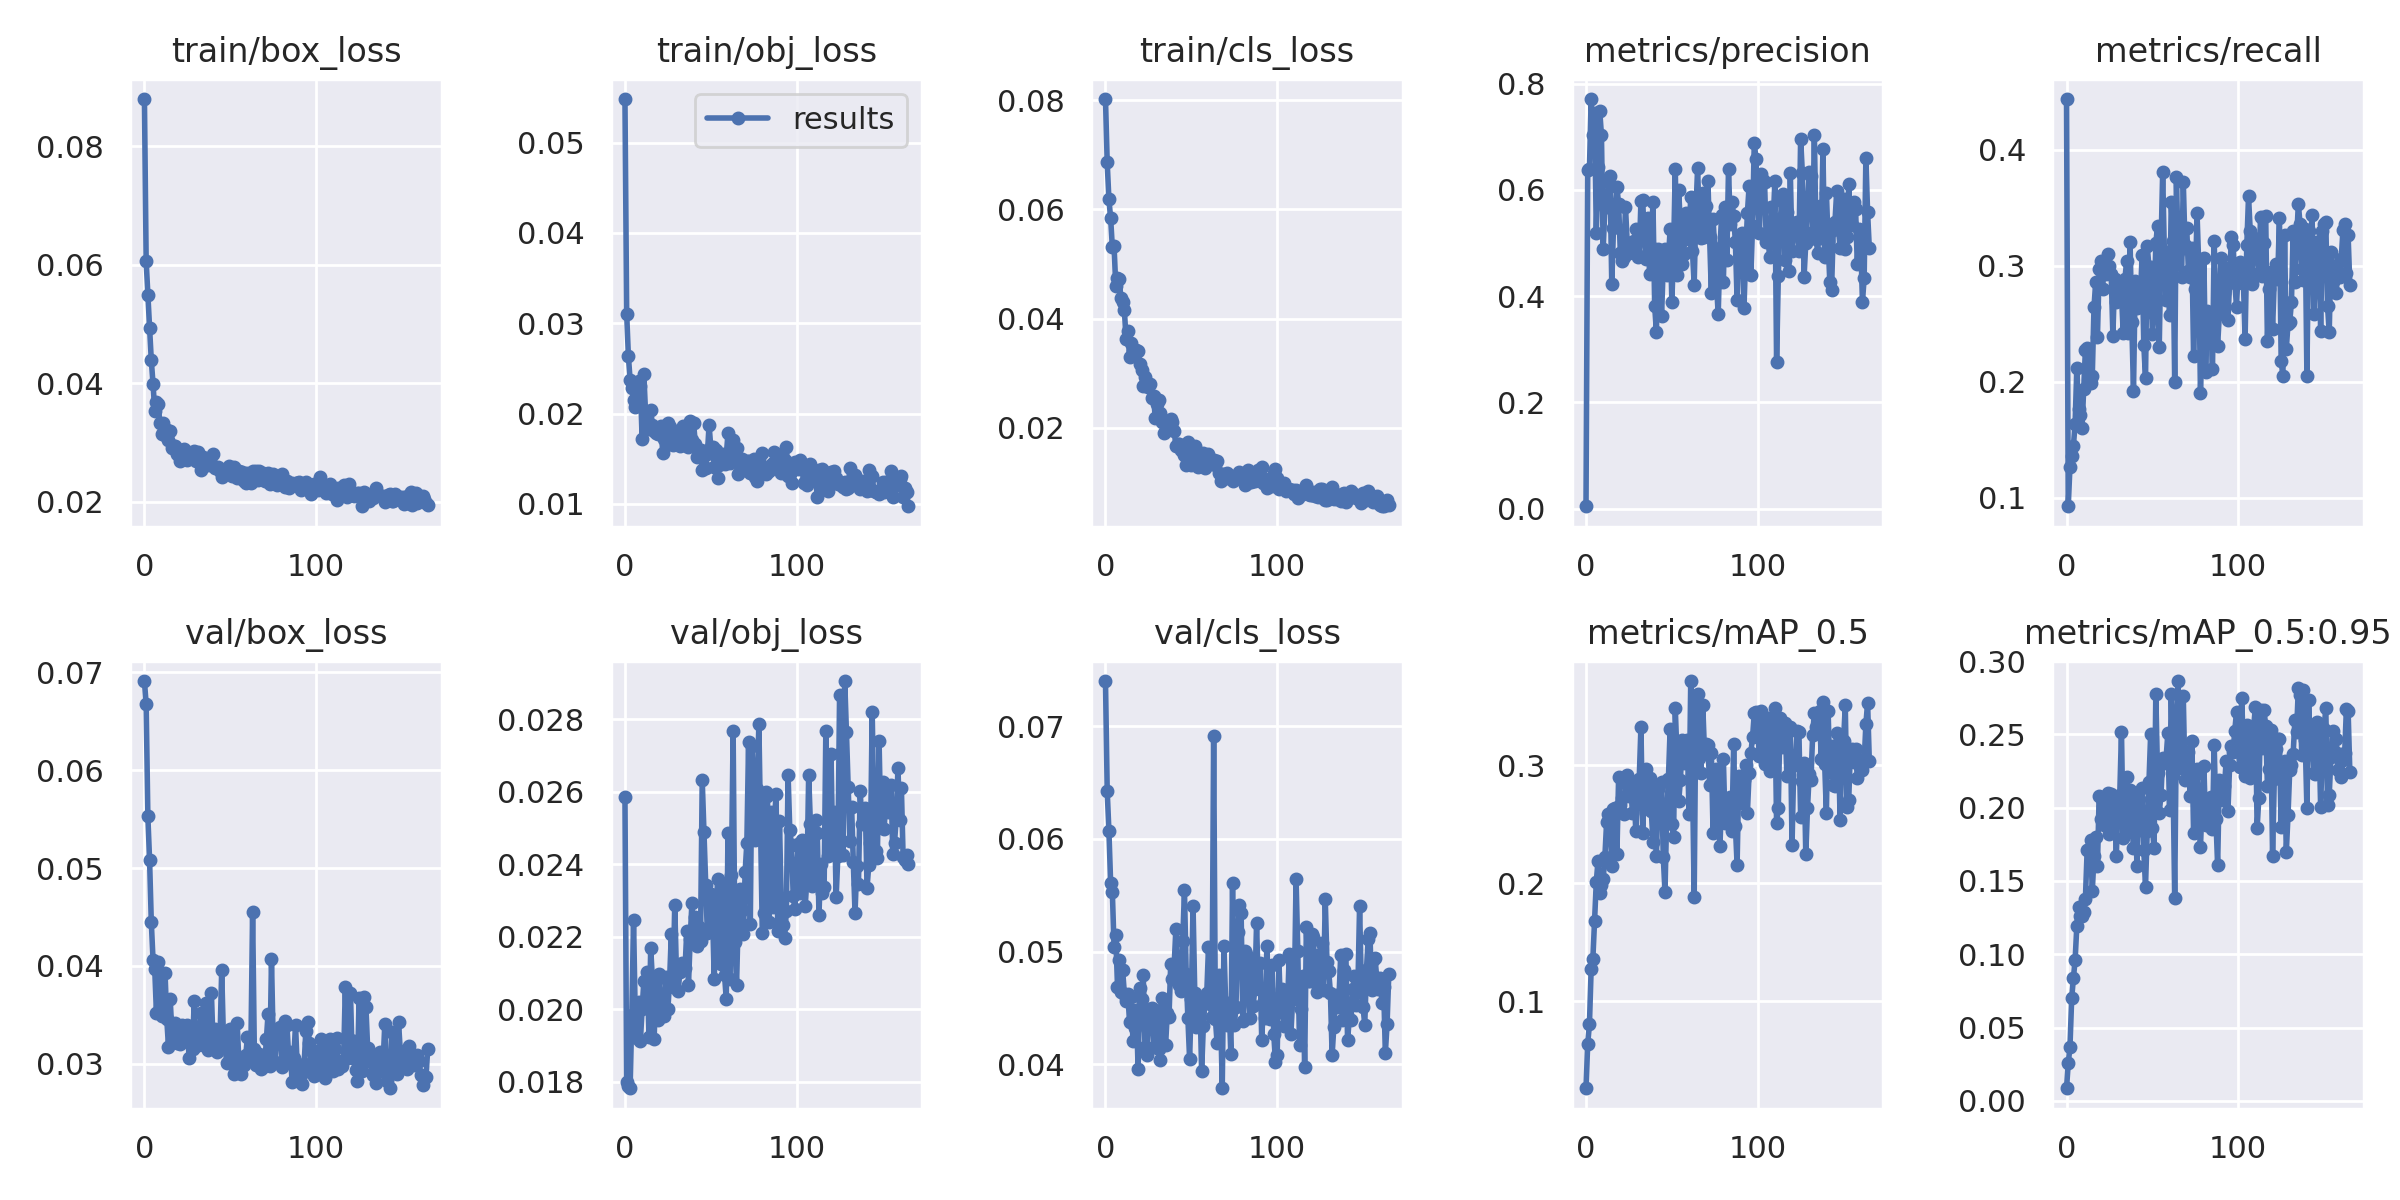

In [67]:
from IPython import display
display.Image("./runs/train/exp/results.png")

In [69]:
!python val.py --data yoloTACO.yaml --weights runs/train/exp5/weights/best.pt

val: data=/usr/src/yolov5/data/yoloTACO.yaml, weights=['runs/train/exp5/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-180-g82bec4c Python-3.8.13 torch-1.12.1+cu113 CUDA:0 (NVIDIA RTX A4000, 16117MiB)

Fusing layers... 
Model summary: 416 layers, 140230396 parameters, 0 gradients, 208.5 GFLOPs
val: Scanning '/usr/src/yoloTACO/labels/val.cache' images and labels... 100 foun
                 Class     Images  Instances          P          R      mAP50   
                   all        100        314      0.444      0.278      0.261      0.187
        Aluminium foil        100          5      0.681        0.4      0.424      0.322
                Bottle        100         30      0.304      0.533       0.43      0.338
     